# Пайплайн

1. Считать все матрицы в `train` и `test` выборки
2. Обучить нейросеть

# Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

plt.rcParams.update({'font.size': 14})

In [2]:
import os

In [3]:
import file2mat as f2m

In [4]:
MSIZE = 256

In [5]:
DATA_DIR = "data"

FOLDERS = [
    "wav",
    "jpg",
    "pdf",
]

FILES = [[] for _ in range(len(FOLDERS))]

for i, folder in enumerate(FOLDERS):
    path = os.path.join(DATA_DIR, folder)
    print(f'Looking files in "{path}"')
    FILES[i] = sorted(map(
        lambda x: os.path.join(DATA_DIR, folder, x),
        os.listdir(path)))

Looking files in "data/wav"
Looking files in "data/jpg"
Looking files in "data/pdf"


In [6]:
N = min(map(len, FILES))

matricies = np.array([
    np.zeros((N, MSIZE, MSIZE)) for _ in range(len(FOLDERS))
])

matricies.shape

(3, 245, 256, 256)

In [11]:
# %%timeit -r 5 -n 5 
# for i, mat in tqdm(enumerate(MUSIC_MATRICIES[:N])):
#     matricies[0][i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))
    
for i in range(len(FOLDERS)):
    for j in tqdm(range(N)):
        file = FILES[i][j]
#         print(file)
        matricies[i][j] = f2m.signature_from_filepath_by2(file, 0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:06<00:00, 40.61it/s]


# Предваритальная обработка

In [12]:
S = 7.0
SIGMA = (S, S)

In [13]:
def smooth(mat):
    return gaussian_filter(mat, SIGMA, mode='constant', cval=mat.mean())

In [15]:
data_mats = np.zeros((len(FOLDERS), N, MSIZE, MSIZE))
data_mats.shape

(3, 245, 256, 256)

In [16]:
# %%timeit -n 5 -r 5
# matricies = np.array(list(map(smooth, matricies)))
for i in range(data_mats.shape[0]):
    for j in tqdm(range(data_mats.shape[1])):
        data_mats[i,j] = smooth(matricies[i][j])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 292.52it/s]


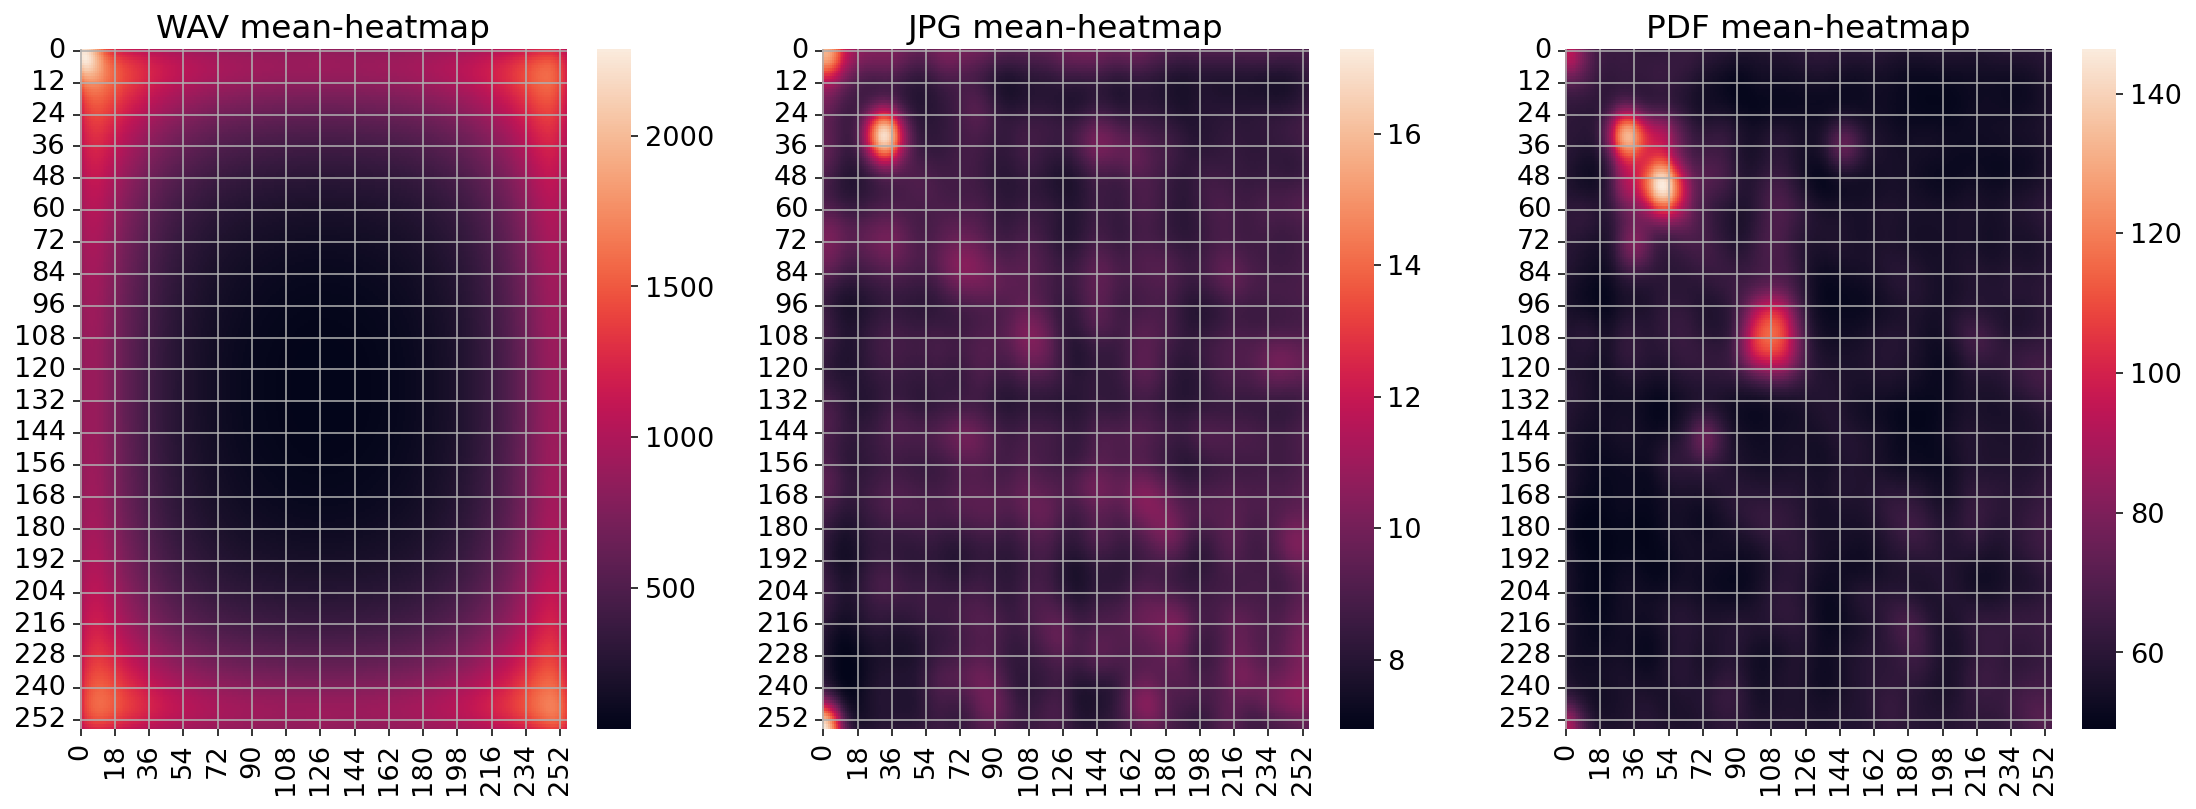

In [24]:
fig, ax = plt.subplots(1, len(FOLDERS), figsize=(16,6), dpi=140)
# ax[0].grid()
# ax.set_xlim(1, 70)
# ax.set(xlabel='common xlabel', ylabel='common ylabel')

title_format = r"{filetype} mean-heatmap"

for i in range(len(FOLDERS)):
    title = title_format.format(filetype = str.upper(FOLDERS[i]))
    ax[i].grid()
    ax[i].set(
        title=title,
    )
    sns.heatmap(data=data_mats[i].mean(axis=0), ax=ax[i])

plt.tight_layout()

# Обучение нейросети

In [25]:
import torch as t
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Подготовка выборок

In [26]:
data_mats.shape

(3, 245, 256, 256)

In [30]:
data = np.zeros((len(FOLDERS) * N, MSIZE, MSIZE))

for i in range(data_mats.shape[0]):
    for j in range(N):
        data[i*N + j] = data_mats[i,j].copy()

data = data.reshape((data.shape[0], MSIZE**2))
print(data.shape)

(735, 65536)


In [31]:
labels = np.zeros((len(FOLDERS)* data_mats.shape[1], 1), dtype=np.uint8)

for i in range(len(FOLDERS)):
#     # WAV - 0
#     # JPG - 1
#     # PDF - 2
    labels[i*N:(i+1)*N] = i

enc = OneHotEncoder()
labels = enc.fit_transform(labels).toarray()

labels.shape, data.shape

((735, 3), (735, 65536))

In [33]:
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=test_size, random_state=1234)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

X_train = t.from_numpy(X_train.astype(np.float32))
X_test = t.from_numpy(X_test.astype(np.float32))
y_train = t.from_numpy(y_train.astype(np.float32))
y_test = t.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], len(FOLDERS))
y_test = y_test.view(y_test.shape[0], len(FOLDERS))

## Формирование нейросети

In [81]:
device = t.accelerator.current_accelerator().type if t.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [92]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(MSIZE**2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Sigmoid(),
#             nn.ReLU(),
            nn.Linear(512, len(FOLDERS))
        )

    def forward(self, x):
#         x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return t.sigmoid(logits)
#         return t.round(logits)

model = NeuralNetwork().to(device)

In [93]:
loss_fn = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=1e-3)

In [94]:
t.set_num_threads(6)

In [95]:
num_epochs = 250

# losses = np.zeros(num_epochs)
# accuracies = np.zeros(num_epochs)
epochs = []
losses = []
accuracies = []


for epoch in range(num_epochs):
    # forward
    y_pred = model(X_train)
    # loss
    loss = loss_fn(y_pred, y_train)
    
    # backward
    loss.backward()
    
    # update
    optimizer.step()
    
    # zero gradient
    optimizer.zero_grad()
    
    # stats
#     losses[epoch] = loss.item()
    

    if (epoch + 1) % (num_epochs // 15 + 1) == 0:
        epochs.append(epoch)
        print(f'epoch {epoch + 1:3d}: loss = {loss.item():.4f}')
        losses.append(loss.item())

        with t.no_grad():
            y_pred = model(X_test)
            y_pred_cls = y_pred.round()

            acc = y_pred_cls.eq(y_test).float().mean(axis=None)
            accuracies.append(acc.item())

epoch  17: loss = 0.9303
epoch  34: loss = 0.8972
epoch  51: loss = 0.8807
epoch  68: loss = 0.8703
epoch  85: loss = 0.8615
epoch 102: loss = 0.8534
epoch 119: loss = 0.8464
epoch 136: loss = 0.8398
epoch 153: loss = 0.8344
epoch 170: loss = 0.8291
epoch 187: loss = 0.8243
epoch 204: loss = 0.8198
epoch 221: loss = 0.8153
epoch 238: loss = 0.8105


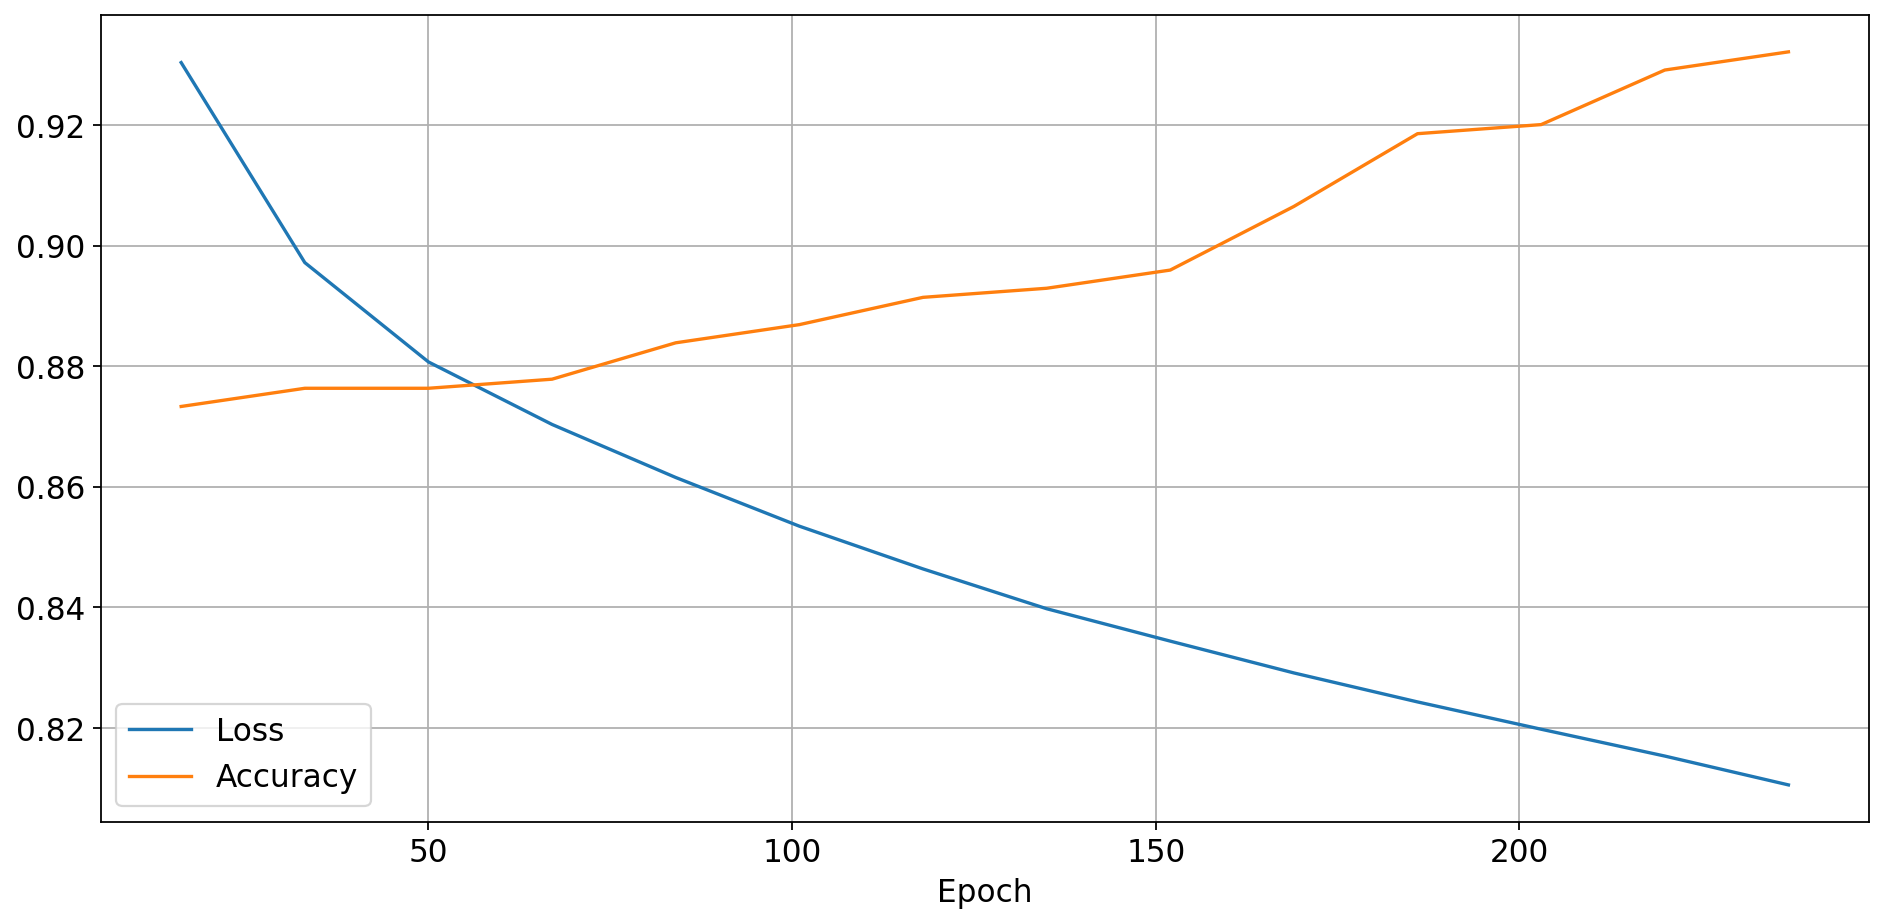

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12,6), dpi=160)

ax.grid()

ax.set(
    xlabel = 'Epoch',
)
sns.lineplot(ax=ax, x=epochs, y=losses, label='Loss')
sns.lineplot(ax=ax, x=epochs, y=accuracies, label='Accuracy')

plt.tight_layout();

In [98]:
with t.no_grad():
    y_pred = model(X_test)
    y_pred_cls = y_pred.round()
    
#     acc = y_pred_cls.eq(y_test).sum() / float(y_test.shape[0])
    acc = y_pred_cls.eq(y_test).float().mean(axis=None)
    print(f'accuracy = {acc:.4f}')

accuracy = 0.9321
